In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def load_features(directory):
    au_features = pd.read_csv('{}/audio_features.csv'.format(directory))
    im_features = pd.read_csv('{}/white_proportion_feature.csv'.format(directory))
    
    # Drop redundant columns
    au_features = au_features.drop(['index'], axis=1)
    im_features = im_features.drop(['label'], axis=1)

    # Merge audio and image features
    features = pd.concat([au_features, im_features], axis=1)

    # Drop unnecessary columns
    features = features.drop(['index','audio_file','image_file','seconds_length'], axis=1)

    # Only look at clips less than 300s long
    features = features[features.length < 300]
    
    return features

In [3]:
features = load_features('labeled')
features.head()

,length,label,last_ring_to_end_length,max_amplitude,mean_nonsilence_variances,mean_silence_length,percent_silence,ring_count,variance_of_nonsilence_variances,white_proportion
0,52.740,0,421632,13201.316993,3288065.630625,5933.142857,0.492515,0,1.022110e+13,0.797400
1,27.000,1,215424,6472.002296,2645716.235082,105198.500000,0.976665,0,NaN,0.976968
2,56.088,0,31969,8450.864654,847573.296409,6104.150000,0.272429,10,7.112465e+11,0.833652
3,215.640,0,13923,8893.500712,757854.577506,2901.904348,0.193511,56,6.715146e+11,0.762843
4,117.216,0,16743,16570.947952,1067439.468707,5541.494118,0.502615,26,8.731344e+12,0.826120


In [4]:
# Take a look at where nan values are
features[features.isnull().any(axis=1)].head()

,length,label,last_ring_to_end_length,max_amplitude,mean_nonsilence_variances,mean_silence_length,percent_silence,ring_count,variance_of_nonsilence_variances,white_proportion
1,27.000,1,215424,6472.002296,2645716.235082,105198.5,0.976665,0,NaN,0.976968
5,27.288,1,217728,6367.894592,2681107.416424,106353.0,0.976935,0,NaN,0.976786
10,24.408,1,194688,6245.208322,2632847.949536,94824.0,0.974112,0,NaN,0.975155
36,26.352,1,210240,6562.299848,2836528.178015,102602.5,0.976051,0,NaN,0.976748
41,6.120,1,48384,6407.513289,2700533.740881,21677.5,0.896061,0,NaN,0.957955


In [5]:
# nan nonsilence variances due to no nonsilences?
features['variance_of_nonsilence_variances'].fillna(0, inplace=True)

# how many remaining rows still have nan values?
len(features[features.isnull().any(axis=1)])

8

In [6]:
# just drop the remaning rows with nan values
features = features.dropna()

In [7]:
from sklearn import cross_validation
columns = ['label', 'white_proportion']
train, test = cross_validation.train_test_split(features[columns], train_size=0.7, random_state=1000)
y_train = train['label']
X_train = train.drop('label', axis=1)
y_test = test['label']
X_test = test.drop('label', axis=1)

In [8]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [9]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
list(zip(columns[1:], lr.coef_[0]))

[('white_proportion', 2.631908655491813)]

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=15, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
list(zip(columns[1:], rf.feature_importances_))

[('white_proportion', 1.0)]

In [11]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf') # available kernels: linear, poly, rbf, sigmoid
svm.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [12]:
from sklearn import metrics
for m in [lr, rf, svm]:
    X_test_scaled = scaler.transform(X_test)
    y_pred = m.predict(X_test_scaled)
    print(metrics.roc_auc_score(y_test, y_pred))

0.823303691956
0.772022223715
0.821897753616


In [13]:
from sklearn.pipeline import make_pipeline

columns = ['length', 'last_ring_to_end_length', 'max_amplitude', 'mean_nonsilence_variances', 'mean_silence_length', 'percent_silence', 'ring_count', 'variance_of_nonsilence_variances', 'white_proportion']
columns = ['white_proportion']

X = features[columns]
y = features['label']

for m in [
    LogisticRegression(),
    RandomForestClassifier(n_estimators=20, n_jobs=-1),
    SVC(kernel='rbf'),
    #SVC(kernel='poly')
]:
    clf = make_pipeline(preprocessing.StandardScaler(), m)
    print(m.__class__.__name__)
    
    # options for scoring: http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    for scorer in ['roc_auc', 'average_precision', 'recall', 'f1']:
        scores = cross_validation.cross_val_score(clf, X, y, cv=10, scoring=scorer, n_jobs=-1)
        print("\t{}: {:.2f} (+/- {:.2f})".format(scorer, scores.mean(), scores.std() * 2))

LogisticRegression
	roc_auc: 0.91 (+/- 0.02)
	average_precision: 0.89 (+/- 0.03)
	recall: 0.77 (+/- 0.05)
	f1: 0.79 (+/- 0.03)
RandomForestClassifier
	roc_auc: 0.85 (+/- 0.03)
	average_precision: 0.83 (+/- 0.04)
	recall: 0.72 (+/- 0.04)
	f1: 0.73 (+/- 0.03)
SVC
	roc_auc: 0.88 (+/- 0.02)
	average_precision: 0.85 (+/- 0.05)
	recall: 0.73 (+/- 0.05)
	f1: 0.79 (+/- 0.03)


# Unlabeled data

In [14]:
unl_features = load_features('unlabeled')
unl_features.head()

,length,last_ring_to_end_length,max_amplitude,mean_nonsilence_variances,mean_silence_length,percent_silence,ring_count,variance_of_nonsilence_variances,white_proportion
0,55.800,37272,7996.032645,669448.850713,6285.941176,0.479386,16,6.392135e+11,0.861486
1,65.880,89501,12669.113234,863777.126124,3489.703125,0.424228,12,4.613365e+12,0.825686
2,9.576,15220,7231.952319,1536114.044238,2255.857143,0.207689,2,1.858999e+12,0.873591
3,5.256,41472,8838.864994,7351102.882874,7540.333333,0.545452,0,5.230724e+13,0.897695
4,5.760,45504,9150.690024,8968169.257656,8529.666667,0.562346,0,6.839469e+13,0.900670


In [17]:
# Take a look at where nan values are
unl_features[unl_features.isnull().any(axis=1)].head()

,length,last_ring_to_end_length,max_amplitude,mean_nonsilence_variances,mean_silence_length,percent_silence,ring_count,variance_of_nonsilence_variances,white_proportion
6,14.184,112896,6016.569319,2230032.565705,53935.5,0.955490,0,NaN,0.969982
10,5.760,45504,6437.568449,2554060.482237,20237.0,0.889460,0,NaN,0.953184
29,10.368,82368,6380.187662,2529937.131279,38666.5,0.938872,0,NaN,0.964543
32,7.776,61632,6423.542019,2642044.227679,28286.5,0.917916,0,NaN,0.958732
57,19.944,158976,6309.792196,2493014.250837,76974.5,0.968379,0,NaN,0.972016


In [18]:
unl_features['variance_of_nonsilence_variances'].fillna(0, inplace=True)
unl_features['mean_nonsilence_variances'].fillna(0, inplace=True)

In [19]:
# just drop the remaning rows with nan values
unl_features = unl_features.dropna()

In [43]:
columns = ['white_proportion', 'length']
models = [
    LogisticRegression(),
    RandomForestClassifier(n_estimators=20, n_jobs=-1),
    SVC(kernel='rbf'),
]
y_train_all = features['label']
X_train_all = features.drop('label', axis=1)[columns]
labels_pred = []

scaler = preprocessing.StandardScaler()
X_train_all_scaled = scaler.fit_transform(X_train_all)
unl_features_scaled = scaler.transform(unl_features[columns])
for m in models:
    print('Training', m.__class__.__name__)
    m.fit(X_train_all_scaled, y_train_all)
    labels_pred.append(m.predict(unl_features_scaled))
len(labels_pred)

Training LogisticRegression
Training RandomForestClassifier
Training SVC


3

In [44]:
for labels in labels_pred:
    print(np.unique(labels, return_counts=True))

(array([0, 1]), array([10319,  8650]))
(array([0, 1]), array([11159,  7810]))
(array([0, 1]), array([10863,  8106]))


In [45]:
# Combine labels from each predictor into a matrix (one row per predictor)
agg_labels = np.vstack(labels_pred)
# Sum each column of labels
al = np.sum(agg_labels, axis=0)

# If at least two predictors predict "1", then "1", else "0"
al[np.where(al <= 1)] = 0
al[np.where(al > 1)] = 1
final_labels = al

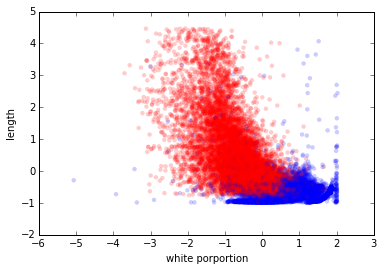

In [55]:
colors = ['#ff0000' if i==0 else '#0000ff' for i in y_train_all]
plt.scatter(y=X_train_all_scaled[:,1], x=X_train_all_scaled[:,0], c=colors, alpha=0.2, linewidth=0)
plt.xlabel('white porportion')
plt.ylabel('length')

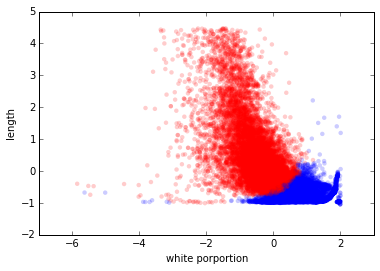

In [56]:
colors = ['#ff0000' if i==0 else '#0000ff' for i in final_labels]
plt.scatter(y=unl_features_scaled[:,1], x=unl_features_scaled[:,0], c=colors, alpha=0.2, linewidth=0)
plt.xlabel('white porportion')
plt.ylabel('length')

In [42]:
np.unique(final_labels, return_counts=True)

(array([0, 1]), array([11170,  7799]))

In [24]:
unlabeled_raw = pd.read_csv('unlabeled/audio_features.csv', index_col='index')
unlabeled_labeled = pd.concat([unlabeled_raw, pd.DataFrame(final_labels, columns=['label'])], axis=1)
unlabeled_labeled = unlabeled_labeled[['audio_file', 'image_file', 'label']]
unlabeled_labeled.head()

,audio_file,image_file,label
0,../output/audio/unl_B-1009-2014-11-26-215804-3...,../output/images/unl_B-1009-2014-11-26-215804-...,0
1,../output/audio/unl_B-1009-2014-11-26-212753-3...,../output/images/unl_B-1009-2014-11-26-212753-...,0
2,../output/audio/unl_B-1009-2014-11-26-210738-2...,../output/images/unl_B-1009-2014-11-26-210738-...,0
3,../output/audio/unl_B-1009-2014-11-26-210722-2...,../output/images/unl_B-1009-2014-11-26-210722-...,1
4,../output/audio/unl_B-1009-2014-11-26-210712-2...,../output/images/unl_B-1009-2014-11-26-210712-...,1


In [28]:
unlabeled_labeled.sample(1).values

array([['../output/audio/unl_B-1009-2014-04-08-081112-8.mp3',
        '../output/images/unl_B-1009-2014-04-08-081112-8.mp3.png', 1.0]], dtype=object)

In [30]:
unlabeled_labeled.sample(1).values

array([['../output/audio/unl_B-1009-2013-12-03-200626-14.mp3',
        '../output/images/unl_B-1009-2013-12-03-200626-14.mp3.png', 1.0]], dtype=object)